In [200]:
%reload_ext autoreload
%autoreload 2

# Competition page
https://www.kaggle.com/c/tweet-sentiment-extraction

## Using following notebooks for inspiration

- https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import numpy as np
import utils

import nltk
from nltk.corpus import stopwords
from collections import Counter

# Reading data

In [202]:
datadir = "data"
train, test, sample = utils.read_data(datadir)

### Sample of `train` dataset

In [18]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### Head of `test` dataset

In [19]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


### Head of `sample_submission`

In [20]:
sample.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


# Row counts

In [21]:
print(f"Records in train = {train.index.size:6,}")
print(f"Records in test  = {test.index.size:6,}")

Records in train = 27,481
Records in test  =  3,534


### Proportion of different sentiments
Proportions are similar between train and test datasets with neutral sentiment as the dominant one

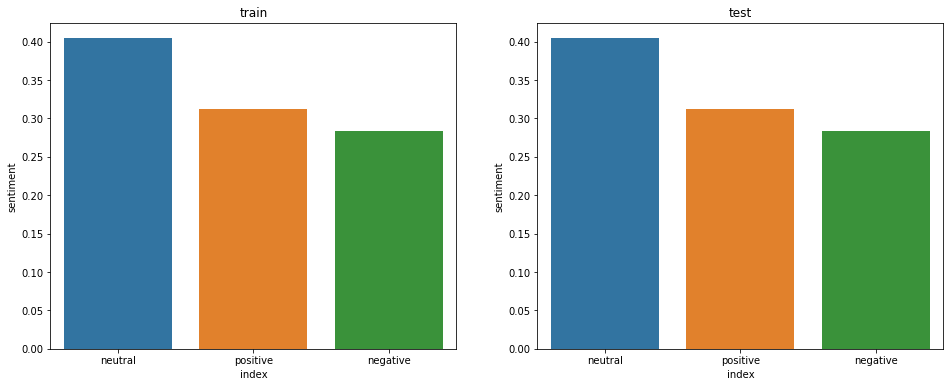

In [22]:
figsize=(16, 6)

f, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)

for ax, data, title in zip(axes, (train, test), ("train", "test")):
    (train
     .sentiment
     .value_counts(normalize=True)
     .reset_index()
     .pipe((sns.barplot, "data"), x="index", y="sentiment", ax=ax)
    )
    ax.set_title(title)

# Sentence lengths (letters)

### Distribution of lengths of the `text` and `selected_text` strings
While the distribution of `text` field is fairly uniform, the distribution of `selected_text` is skewed to the right

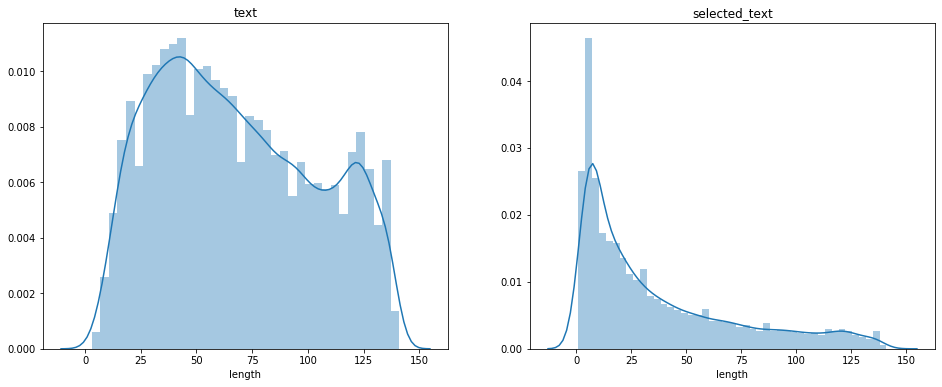

In [62]:
f, axes = plt.subplots(1, 2, figsize=figsize)

for ax, col in zip(axes, ("text", "selected_text")):
    (train
     .assign(
         length=lambda x: x.apply(lambda x: len(str(x[col])), axis=1),
     )
     .length
     .pipe((sns.distplot), ax=ax, label=col)
    )
    ax.set_title(col)

### Here, we see the distributions broken down by sentiment
The distribution for neutral sentiment for `selected_text` is interesting that it isn't positively skewed but more uniform like the distributions of the `text`

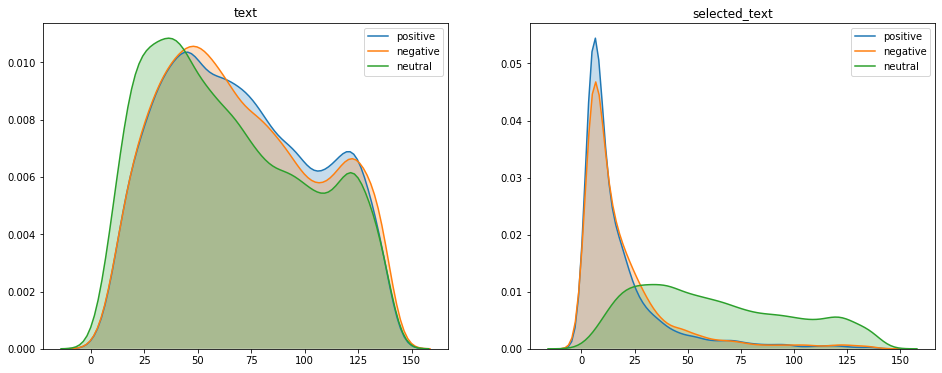

In [32]:
f, axes = plt.subplots(1, 2, figsize=figsize)

for ax, col in zip(axes, ("text", "selected_text")):
    for sentiment in ("positive", "negative", "neutral"):
        (train
         .query("sentiment == @sentiment")
         .assign(
             length=lambda x: x.apply(lambda x: len(str(x[col])), axis=1),
         )
         .length
         .pipe((sns.kdeplot, "data"), ax=ax, label=sentiment, shade=True)
        )
        ax.set_title(col)

# Number of words

### Distribution of number of words of the `text` and `selected_text` strings

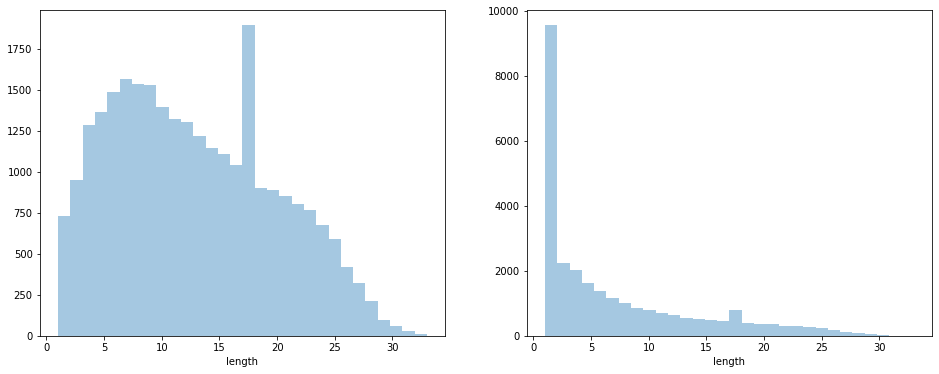

In [129]:
f, axes = plt.subplots(1, 2, figsize=figsize)

for ax, col in zip(axes, ("text", "selected_text")):
    (train
     .dropna()
     .assign(
         length=lambda x: x.apply(lambda x: len(str(x[col]).split()), axis=1),
     )
     .length
     .pipe(sns.distplot, ax=ax, label=col, kde=False, bins=30)
    )

### Here, we see the distributions broken down by sentiment
The distribution for neutral sentiment for `selected_text` is interesting that it isn't positively skewed but more uniform like the distributions of the `text`

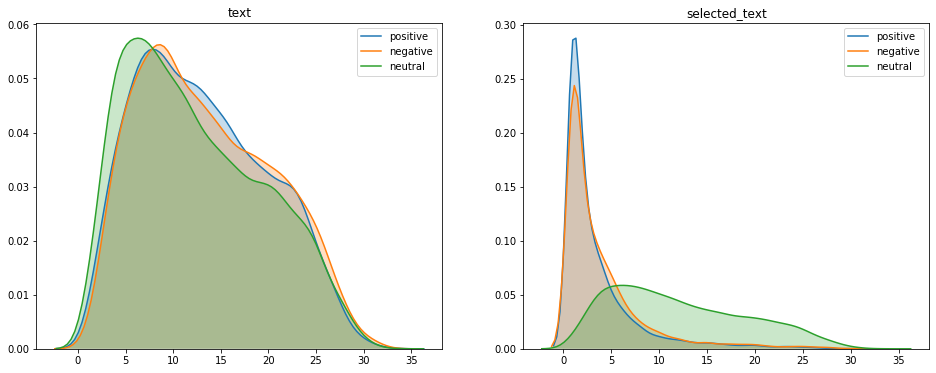

In [34]:
f, axes = plt.subplots(1, 2, figsize=figsize)

for ax, col in zip(axes, ("text", "selected_text")):
    for sentiment in ("positive", "negative", "neutral"):
        (train
         .query("sentiment == @sentiment")
         .assign(
             length=lambda x: x.apply(lambda x: len(str(x[col]).split()), axis=1),
         )
         .length
         .pipe((sns.kdeplot, "data"), ax=ax, label=sentiment, shade=True)
        )
        ax.set_title(col)

### These plots show the distributions for number of words but separated by sentiments
The distribution of `text` and `selected_text` follows a very similar pattern which indicates that the `text` as is could be used for `selected_text` if the sentiment is neutral

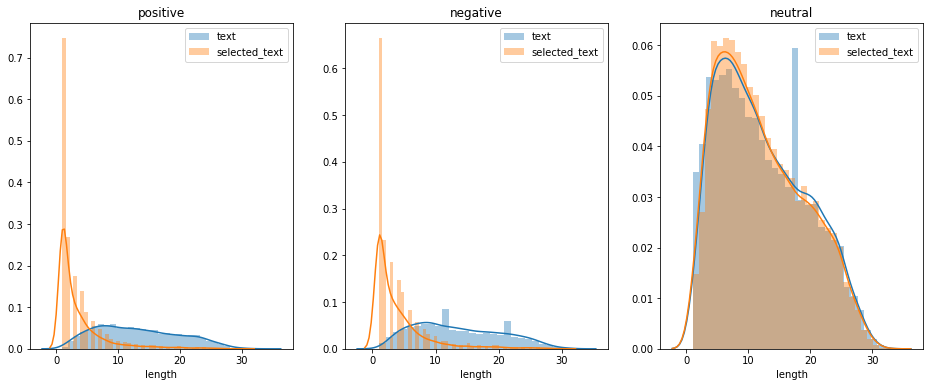

In [61]:
f, axes = plt.subplots(1, 3, figsize=figsize)

for ax, sentiment in zip(axes, ("positive", "negative", "neutral")):
    for col in ("text", "selected_text"):
        (train
         .query("sentiment == @sentiment")
         .assign(
             length=lambda x: x.apply(lambda x: len(str(x[col]).split()), axis=1),
         )
         .length
         .pipe(sns.distplot, ax=ax, label=col)
        )
        ax.set_title(sentiment)
        ax.legend()

# Jaccard similarity

In [94]:
data_jaccard

,textID,text,selected_text,sentiment,jaccard,words_text,words_st_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10,10
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,14,14
...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,0.058824,16,16
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,0.083333,23,23
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,0.272727,22,22
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,1.000000,6,6


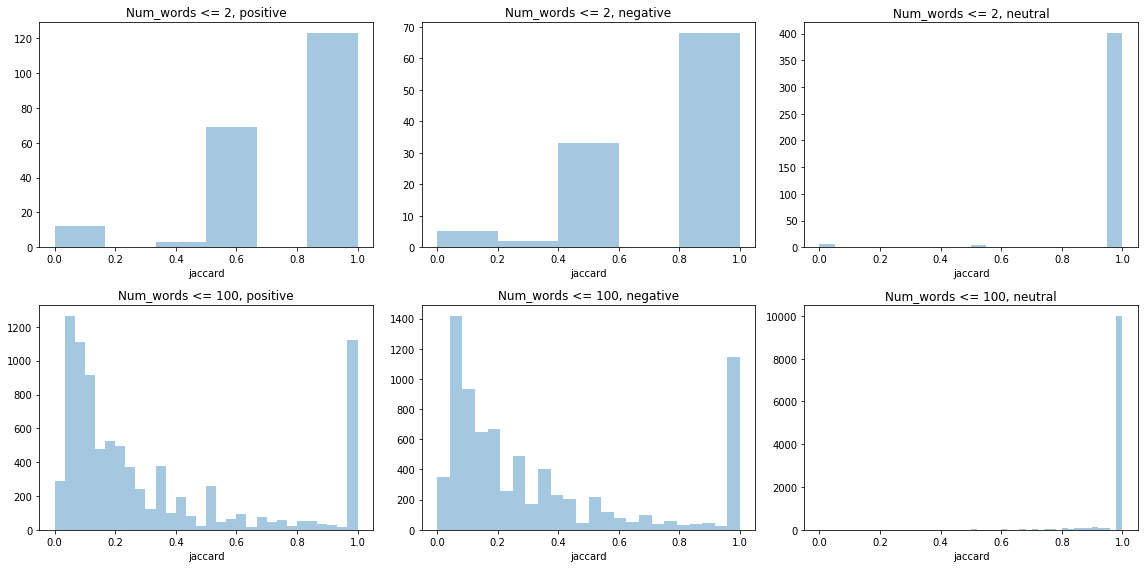

In [96]:
data_jaccard = (train
 .dropna()
 .assign(
     jaccard=lambda x: x.apply(lambda x: utils.jaccard_similarity(x.text, x.selected_text), axis=1),
     words_text=lambda x: x.apply(lambda x: len(x.text.split()), axis=1),
     words_st_text=lambda x: x.apply(lambda x: len(x.text.split()), axis=1)
 )
)

f, axes = plt.subplots(2, 3, figsize=(16, 8))

for num_words, row in zip((2, 100), axes):
    for sentiment, ax in zip(("positive", "negative", "neutral"), row):
        (data_jaccard
         .query("sentiment == @sentiment")
         .query("words_text <= @num_words")
         .jaccard
         .pipe(sns.distplot, ax=ax, kde=False)
        )
        ax.set_title(f"Num_words <= {num_words}, {sentiment}")
        
plt.tight_layout()

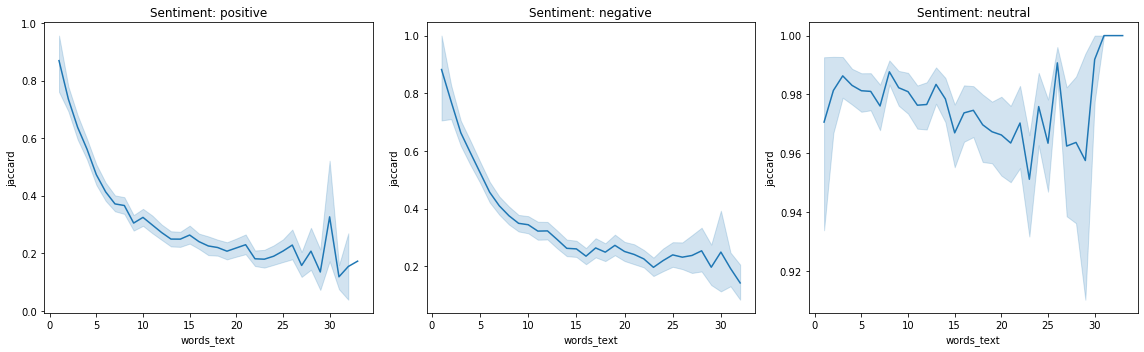

In [104]:
f, axes = plt.subplots(1, 3, figsize=(16, 5))

for sentiment, ax in zip(("positive", "negative", "neutral"), axes):
    (data_jaccard
     .query("sentiment == @sentiment")
     .pipe((sns.lineplot, "data"), x="words_text", y="jaccard", estimator="mean", ax=ax)
    )
    ax.set_title(f"Sentiment: {sentiment}")

plt.tight_layout()

Let's sample a few records where jaccard score is less than 1.0 for neutral sentiments. As we can see there is some behaviour that doesn't fit a pattern. 
- For some cases the only different is punctuation
- For few cases, the first letter has been removed in selected_text

One key insight is that any links have been completely removed in selected_text and hence should be filtered our during data cleaning

In [117]:
(data_jaccard
 .query("sentiment == 'positive'")
 .query("jaccard < 1.0")
 .sort_values("jaccard")[["text", "selected_text", "jaccard", "words_text"]]
 .head(20)
)

,text,selected_text,jaccard,words_text
18773,give them my best!,y best,0.0,4
25760,@_Bella_Cullen13 _Cullen26 _Cullen10 These ...,ls lo,0.0,12
10184,_tall_blonde ~~Hello~~~ and thanks for the ...,nd thank,0.0,7
15217,"caww that sounds good, I hope you`re right",s good,0.0,8
4329,- great site. The photos on it are fantastic...,e fantastic,0.0,22
20451,I really want to be a star...Hope Flawless wil...,Hope Fl,0.0,10
13124,...thanks for the shout out...you might be ri...,.thanks,0.0,14
10179,Going to the alley tonite..Happy Birthday prima,Happy,0.0,7
18745,Welcome home! Glad you made it home safe!,e safe,0.0,8
18403,I just retweeted your jesus post as it made m...,laugh.,0.0,17


# Top words in `text` in train dataset

In [27]:
overall = (train
 .text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

positive = (train
 .query("sentiment == 'positive'")
 .text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

negative = (train
 .query("sentiment == 'negative'")
 .text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

neutral = (train
 .query("sentiment == 'neutral'")
 .text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

top_overall = Counter([item for row in overall for item in row if item not in stopwords.words("english")])
top_positive = Counter([item for row in positive for item in row if item not in stopwords.words("english")])
top_negative = Counter([item for row in negative for item in row if item not in stopwords.words("english")])
top_neutral = Counter([item for row in neutral for item in row if item not in stopwords.words("english")])

(
    pd.concat((
    pd.DataFrame(top_overall.most_common(20), columns=["overall", "count"]),
    pd.DataFrame(top_positive.most_common(20), columns=["positive", "count"]),
    pd.DataFrame(top_negative.most_common(20), columns=["negative", "count"]),
    pd.DataFrame(top_neutral.most_common(20), columns=["neutral", "count"])),
    axis=1)
)


,overall,count,positive,count,negative,count,neutral,count
0,im,3020,day,1223,im,1226,im,1054
1,day,2044,good,1046,like,476,get,623
2,good,1549,love,875,dont,469,go,576
3,get,1426,happy,840,cant,463,day,503
4,like,1346,im,740,get,436,dont,491
5,go,1267,mothers,627,miss,422,going,479
6,dont,1200,thanks,553,go,401,work,477
7,love,1122,great,478,sad,389,like,457
8,work,1112,like,413,work,386,lol,454
9,going,1096,hope,396,sorry,340,got,453


# Top words in `selected_text` for train dataset

In [28]:
overall = (train
 .selected_text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

positive = (train
 .query("sentiment == 'positive'")
 .selected_text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

negative = (train
 .query("sentiment == 'negative'")
 .selected_text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

neutral = (train
 .query("sentiment == 'neutral'")
 .selected_text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

top_overall = Counter([item for row in overall for item in row if item not in stopwords.words("english")])
top_positive = Counter([item for row in positive for item in row if item not in stopwords.words("english")])
top_negative = Counter([item for row in negative for item in row if item not in stopwords.words("english")])
top_neutral = Counter([item for row in neutral for item in row if item not in stopwords.words("english")])

(
    pd.concat((
    pd.DataFrame(top_overall.most_common(20), columns=["overall", "count"]),
    pd.DataFrame(top_positive.most_common(20), columns=["positive", "count"]),
    pd.DataFrame(top_negative.most_common(20), columns=["negative", "count"]),
    pd.DataFrame(top_neutral.most_common(20), columns=["neutral", "count"])),
    axis=1)
)

,overall,count,positive,count,negative,count,neutral,count
0,im,1676,good,826,im,452,im,1039
1,good,1251,happy,730,miss,358,get,612
2,day,1058,love,697,sad,343,go,569
3,love,909,day,456,sorry,300,day,492
4,happy,852,thanks,439,bad,246,dont,482
5,like,774,great,364,hate,230,going,472
6,get,772,fun,287,dont,221,work,467
7,dont,765,nice,267,cant,201,like,445
8,go,700,mothers,259,sick,166,got,441
9,cant,613,hope,245,like,162,today,427


### Does `selected_text` contain hyperlinks

In [185]:
data_lower = (train
 .dropna()
 .assign(
     text=lambda x: x.text.apply(lambda x: x.lower()),
     selected_text=lambda x: x.selected_text.apply(lambda x: x.lower())
 )
)

search = "_"

print(data_lower[data_lower.text.str.contains(search)].sentiment.value_counts())
data_lower[data_lower.text.str.contains(search) & data_lower.selected_text.str.contains(search)].sentiment.value_counts()


neutral     594
positive    442
negative    286
Name: sentiment, dtype: int64


neutral     412
negative     15
positive     10
Name: sentiment, dtype: int64

In [188]:
letters = Counter([letter for sent in data_lower.text.values for letter in sent])
letters.most_common(10)

[(' ', 351192),
 ('e', 147224),
 ('t', 128980),
 ('o', 128154),
 ('a', 111344),
 ('i', 104824),
 ('n', 92123),
 ('s', 83351),
 ('h', 72307),
 ('r', 68771)]